# Starbucks Capstone Challenge

***

## Table of Contents
* [1. Project Definition](#project_setup)
 * [1.1. Introduction by Udacity](#intro_udacity)
 * [1.2. Data Sets](#data_sets)
 * [1.3. Problem Statement](#problem)
* [2. Data Cleaning](#data_cleaning)
 * [2.1. Exploring the Data](#data_explore)
 * [2.2. Transforming the Data Set](#data_transform)
* [3. Data Analyzing](#data_analyze)
  * [3.1. Data Visualization](#data_visual)
  * [3.2. Machine Learning Models](#model)
   * [3.2.1. Random Forest Classifier](#rfc)
   * [3.2.2. Support Vector Machine](#svm)
   * [3.2.3. Metrics and Model Selection](#metrics)

***

## 1. Project Definition<a class="anchor" id="project_setup"></a>

### 1.1. Introduction by Udacity<a class="anchor" id="intro_udacity"></a>

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### 1.2. Data Sets<a class="anchor" id="data_sets"></a>

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

### 1.3. Problem Statement<a class="anchor" id="problem"></a>



***

## 2. Data Cleaning<a class="anchor" id="data_cleaning"></a>

### 2.1. Exploring the Data<a class="anchor" id="data_explore"></a>

In the following cell, I load the data from json files.

In [2]:
import pandas as pd
import numpy as np
import math
import json
import sqlite3
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

After checking the head lines of these three dataframes, I notice that if the `transcript` dataframe is sorted first by `person` and then by `time`, then I can trace the events happening to all customers over time. I am most interested in what happens after an offer is received for each (`person`, `offer id`) pair. Observing the data set, I find that after `offer received`, three types of event could happen over time, being `offer viewed`, `transaction`, and `offer completed`. I observe something counter-intuitive: for some (`person`, `offer id`) pairs, `offer completed` happens before `offer viewed`. I think this is because of some errors in data collection. Because of this observation, I decide to focus only on whether an offer is completed or not, and ignore whether an offer is viewed or not. Again, this is due to the errors in the dataset, and I would love to explore the latter question if a better dataset is available.

In [3]:
transcript.sort_values(by=['person', 'time'], ascending=True, inplace=True)
transcript = transcript.reset_index(drop=True)
transcript.head(20)

,event,person,time,value
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16}
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
5,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57}
7,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
8,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
9,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


In [4]:
sum(transcript['event'] == 'offer received')

76277

### 2.2. Transforming the data set<a class="anchor" id="data_transform"></a>

My goal is to understand what types of offer are more likely to be completed by customers in different demographic groups. To accomplish this goal, I need to create a dataframe, collecting information about whether the received offers are completed by the customers. 

I want to point out two tricky parts in the following code.
- The dictionary keys for the offer id in column `value` are `offer_id` if the corresponding event is `offer received`, while those are `offer id` for all other events. I made use of this while coding.
- It is possible that the same person receives offer A twice, and completes offer A for 0, 1, or 2 times. When there are multiple receiptions and completions of offers for the same (person, offer_id) pair, I assume the earliest received offer is completed also earlier. I realize this assumption by recording the first completed offer in `completed_index` and then only searching for the next completed offer if the same offer id is received for multiple times. Note that I also follow this assumption when collecting the time when offer is received or completed in `time_received` resp. `time_completed`.

In [5]:
customer = [] # empty list to store the customer ids
offer_completed = [0] * transcript['event'].value_counts()['offer received'] # 1 if an offer is completed, 0 otherwise
completed_index = [] # a list to store indices of recorded completed offers to avoid counting the same completed offers for multiple times
offer_id = [] # to store the offer id
time_received = [] # to store the time when offer is received
time_completed = [1000] * transcript['event'].value_counts()['offer received'] # if not completed, value is 1000
index = -1 # to trace the number of the (person, offer id) pair

for i in np.arange(transcript.shape[0]):
    if transcript.iloc[i]['event'] == 'offer received':
        index += 1
        customer.append(transcript.iloc[i]['person'])
        offer_id.append(transcript.iloc[i]['value']['offer id'])
        time_received.append(transcript.iloc[i]['time'])
        j = i+1 # from the next index on, until the customer changes, check whether the particular offer is completed
        while j < transcript.shape[0] and transcript.iloc[j]['person'] == transcript.iloc[i]['person']:
            if transcript.iloc[j]['event'] == 'offer completed' and \
            transcript.iloc[j]['value']['offer_id'] == transcript.iloc[i]['value']['offer id'] and \
            j not in completed_index:
                offer_completed[index] = 1
                time_completed[index] = transcript.iloc[j]['time']
                completed_index.append(j)
                print(i, index, j, transcript.iloc[j]['event'], transcript.iloc[j]['time'])
                break 
            j += 1

5 2 7 offer completed 414
9 3 11 offer completed 528
14 4 16 offer completed 576
30 8 33 offer completed 252
36 10 41 offer completed 576
38 11 42 offer completed 576
45 12 48 offer completed 54
53 14 58 offer completed 510
54 15 59 offer completed 510
65 17 68 offer completed 222
72 18 75 offer completed 378
82 20 85 offer completed 600
91 22 100 offer completed 384
102 24 110 offer completed 504
108 25 116 offer completed 696
126 27 131 offer completed 258
147 32 150 offer completed 534
151 33 154 offer completed 714
155 34 158 offer completed 222
161 35 163 offer completed 336
165 36 168 offer completed 432
170 37 173 offer completed 558
174 38 176 offer completed 576
188 42 192 offer completed 582
194 44 197 offer completed 132
198 45 200 offer completed 414
204 47 206 offer completed 576
227 55 232 offer completed 696
233 57 235 offer completed 12
241 58 243 offer completed 210
248 59 250 offer completed 342
254 61 256 offer completed 534
258 62 260 offer completed 666
269 65 272 

In [6]:
df = pd.DataFrame(list(zip(customer, offer_id, offer_completed, time_received, time_completed)), \
                  columns = ['customer', 'offer_id', 'offer_completed', 'time_received', 'time_completed'])
# check that indeed I have counted the correct numbers of `offer received` and `offer completed`
print('The number of offer received in dataset transcript is ', sum(transcript['event'] == 'offer received'),'\n'\
      'The number of offer received in my df is ', df.shape[0], '\n'\
      'The number of offer completed in dataset transcript is ', sum(transcript['event'] == 'offer completed'),'\n'\
      'The number of offer completed in my df is ', df['offer_completed'].sum(),'\n'\
      'So I have collected the information into df correctly! ')
df.head()

The number of offer received in dataset transcript is  76277 
The number of offer received in my df is  76277 
The number of offer completed in dataset transcript is  33579 
The number of offer completed in my df is  33579 
So I have collected the information into df correctly! 


,customer,offer_id,offer_completed,time_received,time_completed
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,168,1000
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,336,1000
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,408,414
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,504,528
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,576,576


In [2]:
df.describe()

NameError: name 'df' is not defined

In [3]:
# as the cell to collect df takes long, I will store it for later use
# engine = create_engine('sqlite:///offers.db')
# df.to_sql('offers', engine, index=False)

engine = create_engine('sqlite:///offers.db')
offers = pd.read_sql_table('offers', engine)

In [4]:
# I use this cell to debug when I couldn't get the number of completed offer correctly. 
# This is how I found the tricky parts, which are noted in the beginning of this section.
tmp = transcript[transcript['event'] == 'offer completed']['person'].value_counts(ascending=True).to_frame().reset_index()
tmp2 = offers[offers['offer_completed'] == 1]['customer'].value_counts(ascending = True).to_frame().reset_index()
tmp3 = tmp.merge(tmp2)
# store the customers whose number of offer completed in transcript does not match with that in my df
customers = tmp3[tmp3['person'] != tmp3['customer']]['index'].tolist()
# 'person' contains number of offer received in transcript, customer is that number in my df
# if the output is empty, I am doing a good job!
tmp3[tmp3['person'] != tmp3['customer']].sort_values(by=['index'])

,index,person,customer


Now I have a nice dataframe storing all the offers received by customers, whether they are completed or not, and the time when these happened. I am ready to combine the information from `portfolio` and `profile`. First, let us create dummy variables for category columns in these two data sets and convert the date in `profile` to datetime type.

In [4]:
# create dummy variables for portfolio 'channels' and 'offer_type'
portfolio = portfolio.join(pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0))
portfolio = portfolio.join(pd.get_dummies(portfolio['offer_type'].apply(pd.Series).stack()).sum(level=0))
portfolio = portfolio.drop(['channels', 'offer_type'], axis=1)
portfolio

,difficulty,duration,id,reward,email,mobile,social,web,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1,1,0,1,0,1,0


In [5]:
# convert to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'].astype(str), format='%Y%m%d')

In [6]:
print('Notice that among ', profile.shape[0], 'entries, there are ', sum(profile['income'].isnull()), 'NaN in the "income" column.',\
      'and ', sum(profile['gender'].isnull()), 'NaN in the "gender" column. ')
profile.groupby(['gender']).count()

Notice that among  17000 entries, there are  2175 NaN in the "income" column. and  2175 NaN in the "gender" column. 


,age,became_member_on,id,income
gender,,,,
F,6129,6129,6129,6129
M,8484,8484,8484,8484
O,212,212,212,212


For `NaN` in `gender`, I make the assumption that they are the same as `O`. 
For `NaN` in `income`, I fill them with the mean of the rest of the incomes.
I then split the `gender` column into dummy columns.

In [7]:
profile['gender'].fillna('O', inplace=True)
profile['income'].fillna(profile['income'].mean(), inplace=True)
profile = profile.join(pd.get_dummies(profile['gender'].apply(pd.Series).stack()).sum(level=0))
profile = profile.drop(['gender'], axis=1)
profile.head()

,age,became_member_on,id,income,F,M,O
0,118,2017-02-12,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,0,0,1
1,55,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.000000,1,0,0
2,118,2018-07-12,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,0,0,1
3,75,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,1,0,0
4,118,2017-08-04,a03223e636434f42ac4c3df47e8bac43,65404.991568,0,0,1


Now I am ready to merge `df`, `portfolio`, and `profile` together. 

In [8]:
portfolio = portfolio.rename(columns={'id':'offer_id'})
profile = profile.rename(columns={'id':'customer'})
df = pd.merge(offers, portfolio, on=['offer_id'])
df = pd.merge(df, profile, on=['customer'])
print(df.shape)
df.head()

(76277, 21)


,customer,offer_id,offer_completed,time_received,time_completed,difficulty,duration,reward,email,mobile,...,web,bogo,discount,informational,age,became_member_on,income,F,M,O
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,168,1000,0,3,0,1,1,...,0,0,0,1,33,2017-04-21,72000.0,0,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,336,1000,0,4,0,1,1,...,1,0,0,1,33,2017-04-21,72000.0,0,1,0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,408,414,5,5,5,1,1,...,1,1,0,0,33,2017-04-21,72000.0,0,1,0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,504,528,10,10,2,1,1,...,1,0,1,0,33,2017-04-21,72000.0,0,1,0
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,576,576,10,7,2,1,1,...,1,0,1,0,33,2017-04-21,72000.0,0,1,0


## 3. Data Analyzing<a class="anchor" id="data_analyze"></a>

### 3.1. Data Visualization<a class="anchor" id="data_visual"></a>

As the first step of data analyzing, I visualize some data that I am interested in and try to understand what types of customers tend to complete offer.

In [10]:
df_completed  = df[df['offer_completed']==1]
time_diff = df_completed['time_completed'] - df_completed['time_received']

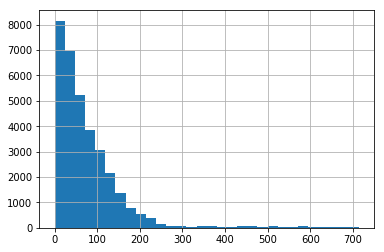

In [11]:
time_diff.hist(bins=30)

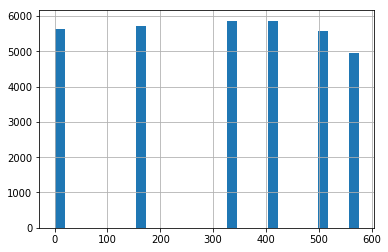

In [12]:
df_completed['time_received'].hist(bins=30)

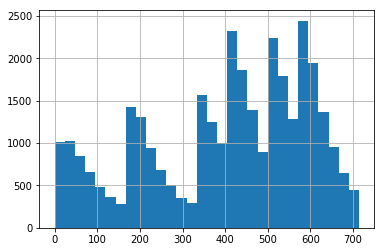

In [13]:
df_completed['time_completed'].hist(bins=30)

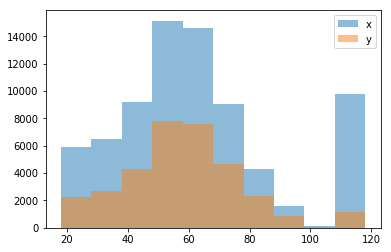

In [14]:
plt.hist(df['age'], alpha=0.5, label='x')
plt.hist(df_completed['age'], alpha=0.5, label='y')
plt.legend(loc='upper right')
plt.show()

In [15]:
print(df['M'].sum(), df_completed['M'].sum(), '\n',\
      df['F'].sum(), df_completed['F'].sum(), '\n',\
      df['O'].sum(), df_completed['O'].sum(), '\n')

38129 16466 
 27456 15477 
 10692 1636 



### 3.2. Machine Learning Models<a class="anchor" id="models"></a>

In this section, my goal is to build a machine learning model to understand what factors contribute to a higher probability of completing offers. In the next cell, I prepare the data set for the model building. 
- I drop several columns that will not help the model achieve its goal and drop the rows with special `age=118` or special `gender=O`, which are essentially those with unknown age or gender.
- I convert the `became_member_on` to int type data, which tells the number of days the customers have been member compared to the oldest (in terms of membership) customer.

In [9]:
print('The number of rows in df is ', df.shape[0], '\n',\
      'The number of rows with age==118 or gender==O is ', df.loc[(df['age'] == 118) | (df['O']==1)].shape[0],'\n',\
      'I choose to drop these rows and the column "O". ')
df_dropped = df.drop(df.loc[(df['age'] == 118) | (df['O']==1)].index)
df_dropped = df_dropped.drop(columns=['O'], axis=1)
df_dropped.shape

The number of rows in df is  76277 
 The number of rows with age==118 or gender==O is  10692 
 I choose to drop these rows and the column "O". 


(65585, 20)

In [10]:
# convert the `became_member_on` to `became_member_days`
df_dropped = df_dropped.assign(became_member_days = (df['became_member_on'] - df['became_member_on'].min()).dt.days)
# a list of the columns that will not be in our training nor test dataset
col_except = ['customer', 'offer_id', 'time_completed', 'became_member_on']
# define X and y data sets for model training
y = df_dropped['offer_completed']
X = df_dropped[list(set(df_dropped.columns) - set(col_except) - {'offer_completed'})]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

#### 3.2.1. Random Forest Classifier<a class="anchor" id="svm"></a>

In the following cells, I tried using Random Forest Classifier for classification. I also used grid search and cross validation to get more robust results. Because of the nature of my df, which is ordered firstly by `customer` and then by `time` (meaning the records of one customer over time are shown, then the records of the next customer over time, etc.), I choose `StratifiedShuffleSplit` while doing cross validation.

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit
param_grid_rfc = {'n_estimators':[100, 200, 300], 'max_depth':[5, 10, None]}
rfc = RandomForestClassifier()
clf_rfc = GridSearchCV(rfc, param_grid=param_grid_rfc, cv=StratifiedShuffleSplit())
clf_rfc.fit(X_train, y_train)
y_pred_rfc = clf_rfc.predict(X_test)

print('Results for Random Forest Classifier with StratifiedShuffleSplit.')
print("\nBest Parameters:", clf_rfc.best_params_)
print('The accuracy score is ', accuracy_score(y_test, y_pred_rfc))
print('\nThe classification report is \n', classification_report(y_test, y_pred_rfc))


Best Parameters: {'max_depth': 10, 'n_estimators': 200}
The accuracy score is  0.620263779828

The classification report is 
              precision    recall  f1-score   support

          0       0.70      0.46      0.55      6708
          1       0.58      0.79      0.67      6409

avg / total       0.64      0.62      0.61     13117



#### 3.2.2. Support Vector Machine<a class="anchor" id="svm"></a>

In the following cells, I use SVM for classification with grid search in `StratifiedShuffleSplit` and cross validation to get more robust results. Following the advice in https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf, I scale all data to be centered and with unit variance, consider rbf kernel, and then use grid search to find the best parameters gamma and C. I am also inspired by the codes in https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py and the discussion about how to standardize data in https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data.

In [15]:
# rescale the data to have mean 0 and var 1
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# use the first two features for svm decision function visualization
X_train_2d = X_train[:, :2]

In [ ]:
from sklearn.svm import SVC
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
clf_svm = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)

print('Results for SVM with StratifiedShuffleSplit.')
print("\nBest Parameters:", clf_svm.best_params_)
print('The accuracy score is ', accuracy_score(y_test, y_pred_svm))
print('\nThe classification report is \n', classification_report(y_test, y_pred_svm))

In [ ]:
# In this cell I directly use the code in 
# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py
# Now we need to fit a classifier for all parameters in the 2d version
# (we use a smaller set of parameters here because it takes a while to train)

C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers_2d = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf_2d = SVC(C=C, gamma=gamma)
        clf_2d.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf_2d))

# draw visualization of parameter effects

plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf_2d)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf_2d.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)), size="medium")

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r, edgecolors="k")
    plt.xticks(())
    plt.yticks(())
    plt.axis("tight")


#### 3.2.3. Metrics and Model Selection<a class="anchor" id="metrics"></a>
\